In [1]:
from nltk.corpus import reuters
from nltk import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.tokenize.toktok import ToktokTokenizer 
import treetaggerwrapper
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline  

from textblob import TextBlob
from textblob.translate import NotTranslated

from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier

from keras.callbacks import Callback
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Activation, Input, Dropout, Dense, Embedding, GlobalMaxPool1D, MaxPooling1D, Flatten, Bidirectional, LSTM 
from keras.models import Model
from keras.optimizers import Adam
from keras import backend as K

from multiprocessing import Pool
from functools import partial
import string
import io
from joblib import Parallel, delayed
import itertools
import time
import tqdm
import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [42]:
# functions for preprocessing

table = {ord(char): u' ' for char in string.punctuation}
toktok = ToktokTokenizer()

# remove punctuation
# tokenize the text
# remove out-of-vocab tokens 
def clean_text(text, vocab=set(), lang='english'):   
    
    text = text.decode('utf-8')
    #for py3:
    #text = text.lower().translate(str.maketrans('','',string.punctuation))  
    text = text.lower()
    table = string.maketrans(string.punctuation, ' '*len(string.punctuation))  
    if lang=='english':
        tokens = word_tokenize(text) 
    else:
        tokens = toktok.tokenize(text, return_str=False)
        
    if vocab:
        tokens = [x for x in tokens if x in vocab]
    joined = ' '.join(tokens).encode('utf-8')
    joined = str(joined)
    return joined

# translate a chuck of text word-by-word using embeddings 
# (of course, a lot of info will be lost this way 
# but it may be sufficient for bag-of-words/bag-of-embeddings 
# representation in classification tasks)
def translate_with_embeddings(text, src_emb, src_id2word, tgt_emb, tgt_id2word):
    text = text.split()
    text = [get_nn(word, src_emb, src_id2word, tgt_emb, tgt_id2word)[0] for word in text]
    text = ' '.join(text)
    return text

# translate a chuck of text word-by-word using 
# bilingual dictionary (provided by FB MUSE)
def translate_with_dict(text, dictionary, vocab=set()):
    text = text.split()
    text = [dictionary[x] for x in text if x in dictionary]
    if vocab:
        text = [x for x in text if x in vocab]
    text = ' '.join(text)
    return text

# translate a sentence using google API 
def translate_sentence_with_google(text, language):    
    try:        
        if hasattr(text, 'decode'):
            text = text.decode('utf-8')
        text = TextBlob(text)
        text = text.translate(to=language)
        return str(text)
    except NotTranslated:
        return str(text)
    except Exception, e:
        print('Failed to translate : {}'.format(str(e)))
        return ''

# translate a chunk of text (multiple sentences) using google API 
def translate_text_with_google(text, language):
    sentences = sent_tokenize(text)
    translated = [translate_sentence_with_google(sent, language) for sent in sentences]
    return ' '.join(translated).strip()

In [28]:
# utils functions

# get k-closest to word_emb indices in the embeddings matrix
def get_closest(word_emb, embeddings, K=1):
    word_emb = np.array(word_emb)
    scores = (embeddings / np.linalg.norm(embeddings, 2, 1)[:, None]).dot(word_emb / np.linalg.norm(word_emb))
    k_best = scores.argsort()[-K:][::-1]
    return k_best

# loading fastText files
# source: https://github.com/facebookresearch/MUSE/blob/master/demo.ipynb
def load_vec(emb_path, nmax=100000):
    vectors = []
    word2id = {}
    with io.open(emb_path, 'r', encoding='utf-8', newline='\n', errors='ignore') as f:
        next(f)
        for i, line in enumerate(f):
            word, vect = line.rstrip().split(' ', 1)
            vect = np.fromstring(vect, sep=' ')
            assert word not in word2id, 'word found twice'
            vectors.append(vect)
            word2id[word] = len(word2id)
            if len(word2id) == nmax:
                break
    id2word = {v: k for k, v in word2id.items()}
    embeddings = np.vstack(vectors)
    return embeddings, id2word, word2id

def get_nn(word, src_emb, src_id2word, tgt_emb, tgt_id2word, K=1):
    word2id = {v: k for k, v in src_id2word.items()}
    word_emb = src_emb[word2id[word]]
    k_best = get_closest(word_emb, tgt_emb, K=K)
    words = [tgt_id2word[i] for i in k_best]
    return words

def load_dict(filename):
    d = {}
    f = open(filename)
    lines = f.readlines()
    for line in lines:
        line = line.split()
        if len(line)==2:
            d[line[0]] = line[1]
    f.close()
    return d 

In [46]:
# functions for modelling

def create_mlp(input_shape, classes=90):
    inp = Input(shape=input_shape)
    x = Dense(256, activation='relu')(inp)
    x = Dropout(0.1)(x)
    x = Dense(256, activation='relu')(x)
    x = Dense(classes)(x)
    x = Activation('sigmoid')(x)
    model = Model(inputs=inp, outputs=x)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[recall, precision])
    return model

def create_model_with_embeddings(embedding_matrix, classes=90, maxlen=650):    
    dim = embedding_matrix.shape[1]
    max_features = embedding_matrix.shape[0]    
    inp = Input(shape=(maxlen,))
    x = Embedding(max_features, dim, weights=[embedding_matrix])(inp)
    x = Dense(300, activation='relu')(x)
    x = GlobalMaxPool1D()(x)
    x = Dense(classes, activation='sigmoid')(x)
    model = Model(inputs=inp, outputs=x)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[recall, precision])
    return model

# construct embedding matrix that will be used as initialization 
# to Keras embedding layer
# make sure that all words in tokenizer.word_index are in word2id vocab
def get_embedding_matrix(embeddings, word2id, tokenizer):
    vocab = []
    dim = embeddings[0].shape[0]
    emb_mean,emb_std = embeddings.mean(), embeddings.std()
    word_index = tokenizer.word_index
    n_words = min(max_features, len(word_index))   
    embedding_matrix = np.random.normal(emb_mean, emb_std, (n_words+1, dim))
    for word, i in word_index.items():
        if i >= max_features: continue
        embedding_vector = embeddings[word2id[word]]
        if embedding_vector is not None: 
            embedding_matrix[i] = embedding_vector
            vocab += [word]
    return embedding_matrix, vocab

# preprocessing pipeline for MLP with Embedding layer
def preprocessing_emb(df, on, max_features=30000, maxlen=650):
    
    tokenizer = Tokenizer(num_words=max_features)
    tokenizer.fit_on_texts(df[on])

    X_train_tokenized = tokenizer.texts_to_sequences(reuters_df[on][reuters_df['split']=='training'])
    X_test_tokenized = tokenizer.texts_to_sequences(reuters_df[on][reuters_df['split']=='test'])

    X_train_padded = pad_sequences(X_train_tokenized, maxlen=maxlen)
    X_test_padded = pad_sequences(X_test_tokenized, maxlen=maxlen)
    
    return X_train_padded, X_test_padded, tokenizer    

In [4]:
# metrics for multilabel classification

# source: https://github.com/fchollet/keras/issues/5400#issuecomment-314747992
def recall(y_true, y_pred, mode='keras'):
    if mode == 'keras':
        x = K
    else:
        x = np
    true_positives = x.sum(x.round(x.clip(y_true * y_pred, 0, 1)))
    possible_positives = x.sum(x.round(x.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())        
    return recall

def precision(y_true, y_pred, mode='keras'):   
    if mode == 'keras':
        x = K
    else:
        x = np
    true_positives = x.sum(x.round(x.clip(y_true * y_pred,0, 1)))
    predicted_positives = x.sum(x.round(x.clip(y_pred,0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

# source: https://github.com/keras-team/keras/issues/3230#issuecomment-319208366
# refer to http://scikit-learn.org/stable/modules/model_evaluation.html#roc-metrics 
# about sklearn.roc_auc_score usage in multilabel setting: 
#'In multi-label classification, the roc_auc_score function is extended by averaging over the labels as above.'
class roc_callback(Callback):
    def __init__(self,training_data,validation_data):
        self.x = training_data[0]
        self.y = training_data[1]
        self.x_val = validation_data[0]
        self.y_val = validation_data[1]

    def on_train_begin(self, logs={}):
        return

    def on_train_end(self, logs={}):
        return

    def on_epoch_begin(self, epoch, logs={}):
        return

    def on_epoch_end(self, epoch, logs={}):
        y_pred = self.model.predict(self.x)
        roc = roc_auc_score(self.y, y_pred)
        y_pred_val = self.model.predict(self.x_val)
        roc_val = roc_auc_score(self.y_val, y_pred_val)
        print('\rroc-auc: {} - roc-auc_val: {}'.format(round(roc,4), round(roc_val,4)))        
        logs['roc-auc'] = round(roc,4)
        logs['val_roc-auc'] = round(roc_val,4)
        return

    def on_batch_begin(self, batch, logs={}):
        return

    def on_batch_end(self, batch, logs={}):
        return

In [5]:
# visualization functions

metrics = [('precision','val_precision'), ('recall','val_recall'), ('roc-auc','val_roc-auc')]

def plot_learning(history, metrics=metrics):
    for training, test in metrics:
        plt.plot(history.history[training])
        plt.plot(history.history[test])
        plt.title('model {}'.format(training))
        plt.ylabel(training)
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()

***EXPLORATION***

In [6]:
documents = reuters.fileids()
train = list(filter(lambda doc: doc.startswith('train'), documents))
test = list(filter(lambda doc: doc.startswith('test'), documents));

print('Total number of docs: {}'.format(len(documents)))
print('Train/test set: {}/{}'.format(len(train),len(test)))

Total number of docs: 10788
Train/test set: 7769/3019


In [7]:
categories = reuters.categories()
print('Total number of categories: {}'.format(len(categories)))

Total number of categories: 90


In [8]:
columns = ['text','split','id','categories']
reuters_df = pd.DataFrame(columns=columns)
text = [reuters.raw(d) for d in documents]
splits = zip(*[d.split('/') for d in documents])
categories = [reuters.categories(d) for d in documents]

reuters_df['text'] = text
reuters_df['split'] = splits[0]
reuters_df['id'] = splits[1]
reuters_df['categories'] = categories
reuters_df['num_categories'] = reuters_df['categories'].apply(lambda x: len(x))

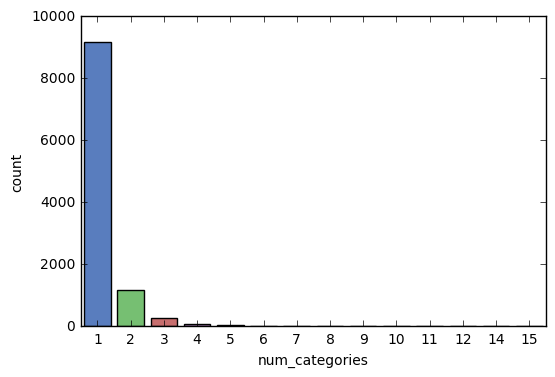

In [9]:
sns.countplot(x='num_categories', data=reuters_df, palette='muted');

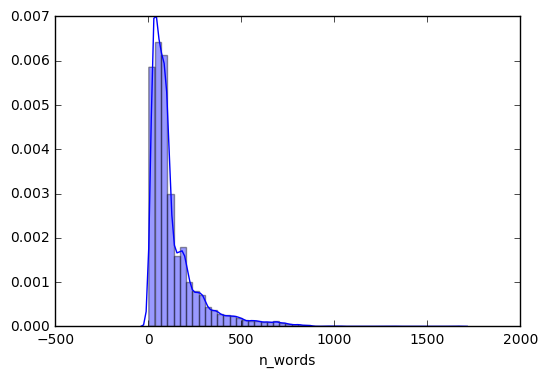

In [10]:
reuters_df['n_words'] = reuters_df['text'].apply(lambda x: len(x.lower().split()))
sns.distplot(reuters_df['n_words']);

***PREPROCESSING***

In [11]:
en_embeddings, en_id2word, en_word2id = load_vec('embeddings/wiki.multi.en.vec')
fr_embeddings, fr_id2word, fr_word2id = load_vec('embeddings/wiki.multi.fr.vec')
de_embeddings, de_id2word, de_word2id = load_vec('embeddings/wiki.multi.de.vec')

In [12]:
reuters_df['text'] = reuters_df['text'].apply(lambda x: x.encode('ascii',errors='ignore')) 

In [13]:
# translating with google api to get some aproximation of ground truth 
parallel = Parallel(100, backend='threading', verbose=0)

for lang in ['de', 'fr']:
    print('Translating text using {0} language'.format(lang))
    translated_data = parallel(delayed(translate_text_with_google)(comment, lang) for comment in reuters_df['text'].values)
    nones = len([True for x in translated_data if x==''])
    print('Number of nontranslated entries: {}'.format(nones))
    reuters_df['text_{}'.format(lang)] = translated_data

Translating text using de language
Number of nontranslated entries: 0
Translating text using fr language
Number of nontranslated entries: 0


In [14]:
# default preprocessing with tf-idf vectorization (english)
reuters_df['cleaned_text'] = reuters_df['text'].apply(lambda x: clean_text(x))
vec = TfidfVectorizer()

X_train_tfidf = vec.fit_transform(reuters_df['cleaned_text'][reuters_df['split']=='training'])
X_test_tfidf = vec.transform(reuters_df['cleaned_text'][reuters_df['split']=='test'])

n_vocab = X_train_tfidf.shape[1]
print('TFIDF Vocab size: {}'.format(n_vocab))

TFIDF Vocab size: 26277


In [15]:
enc = MultiLabelBinarizer()
y_train = enc.fit_transform(reuters_df['categories'][reuters_df['split']=='training'])
y_test = enc.transform(reuters_df['categories'][reuters_df['split']=='test'])

***kNN CLASSIFIER***

In [16]:
# using all words (with out-of-vocab tokens)
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_tfidf, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [17]:
y_pred = knn.predict(X_test_tfidf)
precision_score = precision(y_test, y_pred, mode='')
recall_score = recall(y_test, y_pred, mode='')
auc_score = roc_auc_score(y_test, y_pred)
print('kNN Classifier results:')
print('precision score: {}'.format(precision_score))
print('recall score: {}'.format(recall_score))
print('auc score: {}'.format(auc_score))

kNN Classifier results:
precision score: 0.843005497836
recall score: 0.73717948716
auc score: 0.679310624124


***MULTILAYER PERCEPTRON WITH TFIDF***

In [21]:
input_shape = (X_train_tfidf.shape[1],)
model_mlp = create_mlp(input_shape=input_shape)
model_mlp.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 26277)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               6727168   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_3 (Dense)              (None, 90)                23130     
_________________________________________________________________
activation_1 (Activation)    (None, 90)                0         
Total params: 6,816,090
Trainable params: 6,816,090
Non-trainable params: 0
_________________________________________________________________


In [22]:
n_epochs = 15
validation_data=(X_test_tfidf, y_test)
training_data=(X_train_tfidf, y_train)
history_mlp = model_mlp.fit(X_train_tfidf, y_train, batch_size=64, epochs=n_epochs, 
                            validation_data=validation_data, callbacks=[roc_callback(training_data=training_data, 
                            validation_data=validation_data)], shuffle=True, verbose=0)

roc-auc: 0.781 - roc-auc_val: 0.7563
roc-auc: 0.9255 - roc-auc_val: 0.8721
roc-auc: 0.9754 - roc-auc_val: 0.9254
roc-auc: 0.9905 - roc-auc_val: 0.9507
roc-auc: 0.9957 - roc-auc_val: 0.9616
roc-auc: 0.9986 - roc-auc_val: 0.9701
roc-auc: 0.9994 - roc-auc_val: 0.9755
roc-auc: 0.9998 - roc-auc_val: 0.9779
roc-auc: 0.9999 - roc-auc_val: 0.9791
roc-auc: 0.9999 - roc-auc_val: 0.98
roc-auc: 1.0 - roc-auc_val: 0.9804
roc-auc: 1.0 - roc-auc_val: 0.9805
roc-auc: 1.0 - roc-auc_val: 0.981
roc-auc: 1.0 - roc-auc_val: 0.9805
roc-auc: 1.0 - roc-auc_val: 0.9797


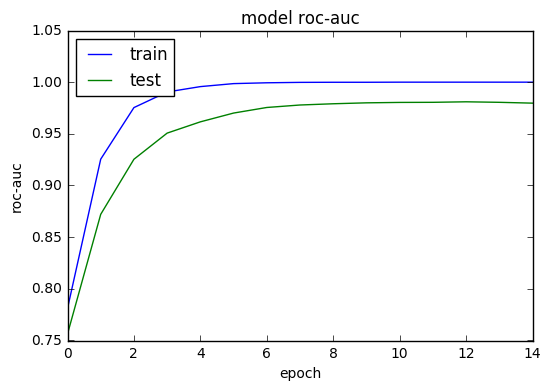

In [23]:
plot_learning(history_mlp, metrics = [('roc-auc', 'val_roc-auc')])

In [ ]:
'''
y_pred = model_mlp.predict([X_test_tfidf], batch_size=1024, verbose=1)
precision_score = precision(y_test, y_pred, mode='')
recall_score = recall(y_test, y_pred, mode='')
auc_score = roc_auc_score(y_test, y_pred)
print('MLP results:')
print('precision score: {}'.format(precision_score))
print('recall score: {}'.format(recall_score))
print('auc score: {}'.format(auc_score))
'''

***MULTILAYER PERCEPTRON WITH EMBEDDINGS LAYER***

In [55]:
# default preprocessing with embeddings vectorization (english), removal of out-of-vocab (oov) tokens
vocab_en = set(en_word2id.keys())
reuters_df['cleaned_text'] = reuters_df['text'].apply(lambda x: clean_text(x, vocab=vocab_en))

X_train_padded, X_test_padded, tokenizer = preprocessing_emb(df=reuters_df, on='cleaned_text')

In [56]:
matrix_en, vocab_en = get_embedding_matrix(en_embeddings, en_word2id, tokenizer)
model_emb = create_model_with_embeddings(matrix_en)
model_emb.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 650)               0         
_________________________________________________________________
embedding_7 (Embedding)      (None, 650, 300)          5869200   
_________________________________________________________________
dense_16 (Dense)             (None, 650, 300)          90300     
_________________________________________________________________
global_max_pooling1d_7 (Glob (None, 300)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 90)                27090     
Total params: 5,986,590
Trainable params: 5,986,590
Non-trainable params: 0
_________________________________________________________________


In [57]:
n_epochs = 15
validation_data = (X_test_padded, y_test)
training_data = (X_train_padded, y_train)
history_emb = model_emb.fit(X_train_padded, y_train, batch_size=64, epochs=n_epochs, 
                            validation_data=validation_data, callbacks=[roc_callback(training_data=training_data, 
                            validation_data=validation_data)], shuffle=True, verbose=0)

roc-auc: 0.7511 - roc-auc_val: 0.7507
roc-auc: 0.8244 - roc-auc_val: 0.8199
roc-auc: 0.8835 - roc-auc_val: 0.8613
roc-auc: 0.9258 - roc-auc_val: 0.8905
roc-auc: 0.9584 - roc-auc_val: 0.9096
roc-auc: 0.978 - roc-auc_val: 0.9266
roc-auc: 0.9905 - roc-auc_val: 0.9427
roc-auc: 0.9961 - roc-auc_val: 0.9537
roc-auc: 0.9983 - roc-auc_val: 0.9613
roc-auc: 0.9992 - roc-auc_val: 0.9678
roc-auc: 0.9997 - roc-auc_val: 0.9714
roc-auc: 0.9998 - roc-auc_val: 0.9705
roc-auc: 0.9999 - roc-auc_val: 0.9716
roc-auc: 0.9999 - roc-auc_val: 0.9719
roc-auc: 0.9999 - roc-auc_val: 0.9702


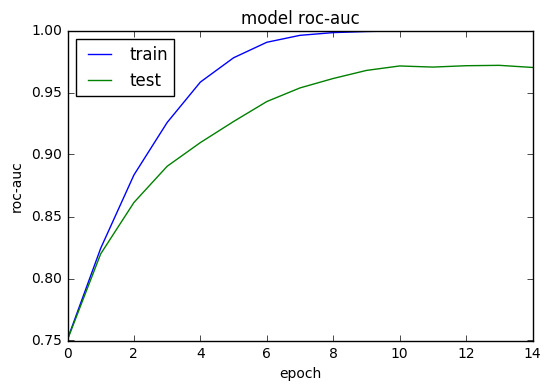

In [58]:
plot_learning(history_emb, metrics = [('roc-auc', 'val_roc-auc')])

In [ ]:
'''
y_pred = model.predict([X_test_padded], batch_size=1024, verbose=1)
precision_score = precision(y_test, y_pred, mode='')
recall_score = recall(y_test, y_pred, mode='')
auc_score = roc_auc_score(y_test, y_pred)
print('MLP with embeddings results:')
print('precision score: {}'.format(precision_score))
print('recall score: {}'.format(recall_score))
print('auc score: {}'.format(auc_score))
'''

***EXTENDING TO FRENCH AND GERMAN***


In [59]:
dict_fr = load_dict('bi/en-fr.txt')
dict_de = load_dict('bi/en-de.txt')

vocab_fr = set(fr_word2id.keys())
vocab_de = set(de_word2id.keys())

In [60]:
# word-by-translation
reuters_df['text_wbw_fr'] = reuters_df['cleaned_text'].apply(lambda x: translate_with_dict(x, dict_fr, vocab=vocab_fr))
reuters_df['text_wbw_de'] = reuters_df['cleaned_text'].apply(lambda x: translate_with_dict(x, dict_de, vocab=vocab_de))

In [61]:
# french
max_features = 30000
maxlen = 650

X_train_padded, X_test_padded, tokenizer = preprocessing_emb(df=reuters_df, on='text_wbw_fr')

matrix_fr, vocab_fr = get_embedding_matrix(fr_embeddings, fr_word2id, tokenizer)
model_emb_fr = create_model_with_embeddings(matrix_fr)

n_epochs = 15
validation_data = (X_test_padded, y_test)
training_data = (X_train_padded, y_train)
history_emb_fr = model_emb_fr.fit(X_train_padded, y_train, batch_size=64, epochs=n_epochs, 
                    validation_data=validation_data, callbacks=[roc_callback(training_data=training_data, 
                    validation_data=validation_data)], shuffle=True, verbose=0)

roc-auc: 0.7251 - roc-auc_val: 0.7311
roc-auc: 0.8014 - roc-auc_val: 0.7961
roc-auc: 0.8545 - roc-auc_val: 0.8358
roc-auc: 0.8973 - roc-auc_val: 0.8613
roc-auc: 0.9293 - roc-auc_val: 0.8801
roc-auc: 0.9557 - roc-auc_val: 0.8999
roc-auc: 0.9772 - roc-auc_val: 0.9178
roc-auc: 0.9899 - roc-auc_val: 0.9307
roc-auc: 0.9955 - roc-auc_val: 0.9401
roc-auc: 0.9975 - roc-auc_val: 0.9445
roc-auc: 0.9989 - roc-auc_val: 0.9518
roc-auc: 0.9994 - roc-auc_val: 0.9557
roc-auc: 0.9997 - roc-auc_val: 0.9572
roc-auc: 0.9998 - roc-auc_val: 0.9589
roc-auc: 0.9999 - roc-auc_val: 0.9605


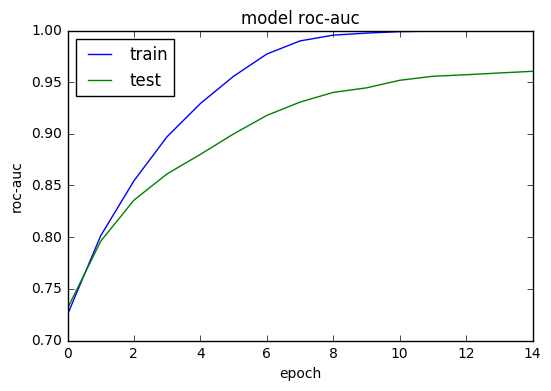

In [62]:
plot_learning(history_emb_fr, metrics = [('roc-auc', 'val_roc-auc')])

In [63]:
# german
X_train_padded, X_test_padded, tokenizer = preprocessing_emb(df=reuters_df, on='text_wbw_de')

matrix_de, vocab_de = get_embedding_matrix(de_embeddings, de_word2id, tokenizer)
model_emb_de = create_model_with_embeddings(matrix_de)

n_epochs = 15
validation_data = (X_test_padded, y_test)
training_data = (X_train_padded, y_train)
history_emb_de = model_emb_de.fit(X_train_padded, y_train, batch_size=64, epochs=n_epochs, 
                            validation_data=validation_data, callbacks=[roc_callback(training_data=training_data, 
                            validation_data=validation_data)], shuffle=True, verbose=0)

roc-auc: 0.7304 - roc-auc_val: 0.7101
roc-auc: 0.8106 - roc-auc_val: 0.7968
roc-auc: 0.8654 - roc-auc_val: 0.8401
roc-auc: 0.903 - roc-auc_val: 0.8728
roc-auc: 0.9345 - roc-auc_val: 0.8998
roc-auc: 0.9614 - roc-auc_val: 0.9191
roc-auc: 0.9816 - roc-auc_val: 0.9346
roc-auc: 0.9905 - roc-auc_val: 0.9428
roc-auc: 0.9956 - roc-auc_val: 0.9503
roc-auc: 0.998 - roc-auc_val: 0.9546
roc-auc: 0.9991 - roc-auc_val: 0.9562
roc-auc: 0.9995 - roc-auc_val: 0.9562
roc-auc: 0.9997 - roc-auc_val: 0.9584
roc-auc: 0.9998 - roc-auc_val: 0.9579
roc-auc: 0.9999 - roc-auc_val: 0.9573


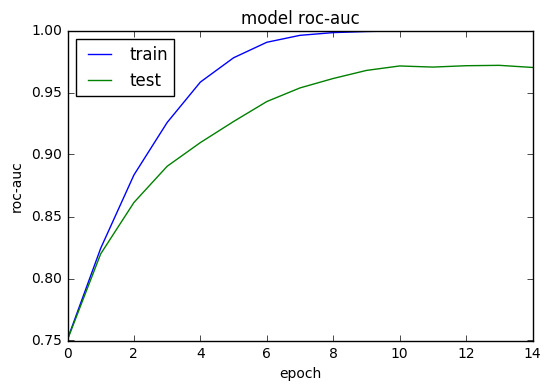

In [64]:
plot_learning(history_emb, metrics = [('roc-auc', 'val_roc-auc')])